In [13]:
# Нужные модули

import numpy as np
from numpy.random import rand
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import math
import sys
sys.path.append('/Users/hrenkovila/Documents/github/py_utils')
from utils import logger
from random import uniform, choice
from exponential_graph import exponential_graph

Полезные статьи: <br>

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0170467 <br>
http://www.machinelearning.ru/wiki/images/5/57/Romovpa_bmml_ising.pdf <br>
https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%98%D0%B7%D0%B8%D0%BD%D0%B3%D0%B0 <br>
https://en.wikipedia.org/wiki/Ising_model <br>
https://stanford.edu/~jeffjar/statmech/intro4.html

**Тема:** <br>
Критические переходы в бинарной модели Изинга на сети Ватца–Строгаца и случайной экспоненциальной сети (получить фазовую диаграмму (параметр порядка vs. управляющий параметр), изменение фрактальной размерности, изменение числа активных узлов во времени)

План: <br>
- Построить рандомные сети (Ватца-Строгаца и эксп. сети)
- Научиться писать и написать алгоритм для симуляции модели Изинга
- Прогнать алгоритм над сетью
- Нарисовать график от управляющего параметра (это склонность к изменению)
- Использовать активность узлов
- Посчитать фрактальную размерность сети

Берется случайная точка на решетке. <br> 
Моделируется случай, перейдет ли она из состояние 1 в 0 (или наоборот). <br>
Препдополгаем, что он переходит в другое состояние, вычисляем его энергию в новом состоянии. Если она уменьшиласт, то он меняет состояние, если увеличилась, то он меняет состояние с заданной вероятностью

In [14]:
class Ising():
    
    def mcmove(self, G, beta):
        """
        G - graph to perform simulation on
        """
        N = len(G.nodes)
        
        for i in range(N):
            
            node = np.random.randint(0, N)
            spin = G.nodes[node]['spin']
            
            nb_spin = 0
            
            for nb in G[node]:
                
                J = G.edges.get((node, nb)).get('J')
                
                if J is not None:
                    nb_spin += J * G.nodes[nb]['spin']
                    
                else:
                    nb_spin += G.nodes[nb]['spin']
                
            cost = 2 * spin * nb_spin
            
            if cost < 0:
                spin *= -1
                
            elif rand() < np.exp(-cost * beta):
                spin *= -1
                
            G.nodes[node]['spin'] = spin
            
            return G
    
    def calcMag(self, G):
        
        sum_spin = 0
        
        for node in G.nodes:
            sum_spin += G.nodes[node]['spin']
            
        return sum_spin
    
    def calcEnergy(self, G):
        
        N = len(G.nodes)
        energy = 0 

        for i in range(N):
                
            S = G.nodes[i]['spin']
            
            nb_energy = 0
            
            for nb in G[i]:
                
                J = G.edges.get((i, nb)).get('J')
                
                if J is not None:    
                    nb_energy += J * G.nodes[nb]['spin']
                    
                else:
                    nb_energy += G.nodes[nb]['spin']

            energy += -nb_energy * S
                
        return energy / 2.
    
    
    def simulate(self, G, temp=0.4, steps=128):   
        """
        G - graph to perform simulation on
        """
        
        E1 = M1 = 0
        
        n1  = 1.0 / (steps * len(G.nodes))
        
        for i in range(steps):
            
            G = self.mcmove(G, 1.0 / temp)
            
            Ene = self.calcEnergy(G)     # подсчитывая энергию (независимость),
            Mag = self.calcMag(G)        # подсчитывая магнетизм (совокупное общественное мнение)

            E1 = E1 + Ene                # вычисляя совокупные энергию и магнетизм
            M1 = M1 + Mag
            
        return M1 * n1, E1 * n1

In [62]:
# ----------------------------------- Ватц-Строгац

# Конфигурация для генерации графа

NODES_NUM: int = 107
SEED: int = 5102021

ws_g = nx.watts_strogatz_graph(n=NODES_NUM, p=.5, k=5, seed=SEED)

# Присвоим каждому узлу графа ориентированность

spins = np.random.choice(
    a=[-1, 1], 
    p=[.5, .5], 
    size=NODES_NUM
)

for node in ws_g.nodes:
    
    ws_g.nodes[node]['spin'] = spins[node]
    ws_g.nodes[node]['is_active'] = (spins[node] + 1) / 2
    
# for edge in ws_g.edges():
    
#     ws_g.edges[edge]['J'] = uniform(0.1, 1)
    
    
logger.info('Graph is generated. Spins are configured. ')

2021-10-16 20:32:39.278 - [INFO] root [1500178083.<module>:28]: Graph is generated. Spins are configured. 


In [63]:
np.random.seed(SEED)
model = Ising()


In [71]:
colors = []
for node in ws_g.nodes:
    
    if ws_g.nodes[node]['spin'] == 1:
        
        colors.append('green')
    else:
        colors.append('red')

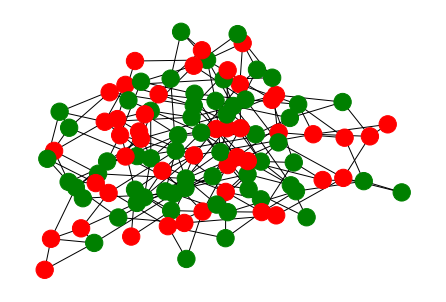

In [72]:
nx.draw(ws_g, node_color=colors)

In [73]:
model.simulate(
    G=ws_g, 
    temp=1/2.5, 
    steps=2**13
)

(0.9659321152161214, -1.9402585608936915)

In [74]:
colors = []

for node in ws_g.nodes:
    
    if ws_g.nodes[node]['spin'] == 1:
        
        colors.append('green')
    else:
        colors.append('red')

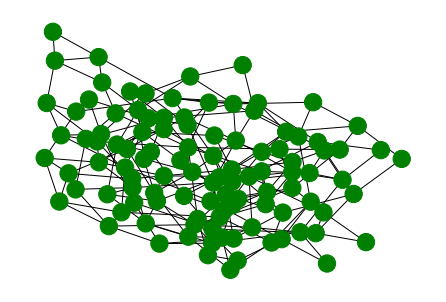

In [75]:
nx.draw(ws_g, node_color=colors)

In [17]:
nt = 64

T = np.linspace(0.1, 4.9, nt)
E, M = np.zeros(nt), np.zeros(nt)    # начальные матрицы значений энергии и магнетизма

In [18]:
for tt in range(nt):
    
    logger.info(f'Going {tt}')
    
    M[tt], E[tt] = model.simulate(
        G=ws_g.copy(), 
        temp=T[tt], 
        steps=2**13
    )

2021-10-16 19:19:11.282 - [INFO] root [710472958.<module>:3]: Going 0
2021-10-16 19:19:36.612 - [INFO] root [710472958.<module>:3]: Going 1
2021-10-16 19:20:01.270 - [INFO] root [710472958.<module>:3]: Going 2
2021-10-16 19:20:25.711 - [INFO] root [710472958.<module>:3]: Going 3
2021-10-16 19:20:50.058 - [INFO] root [710472958.<module>:3]: Going 4
2021-10-16 19:21:14.213 - [INFO] root [710472958.<module>:3]: Going 5
2021-10-16 19:21:38.443 - [INFO] root [710472958.<module>:3]: Going 6
2021-10-16 19:22:02.594 - [INFO] root [710472958.<module>:3]: Going 7
2021-10-16 19:22:27.109 - [INFO] root [710472958.<module>:3]: Going 8
2021-10-16 19:22:51.565 - [INFO] root [710472958.<module>:3]: Going 9
2021-10-16 19:23:16.115 - [INFO] root [710472958.<module>:3]: Going 10
2021-10-16 19:23:40.555 - [INFO] root [710472958.<module>:3]: Going 11
2021-10-16 19:24:04.580 - [INFO] root [710472958.<module>:3]: Going 12
2021-10-16 19:24:28.992 - [INFO] root [710472958.<module>:3]: Going 13
2021-10-16 19:24

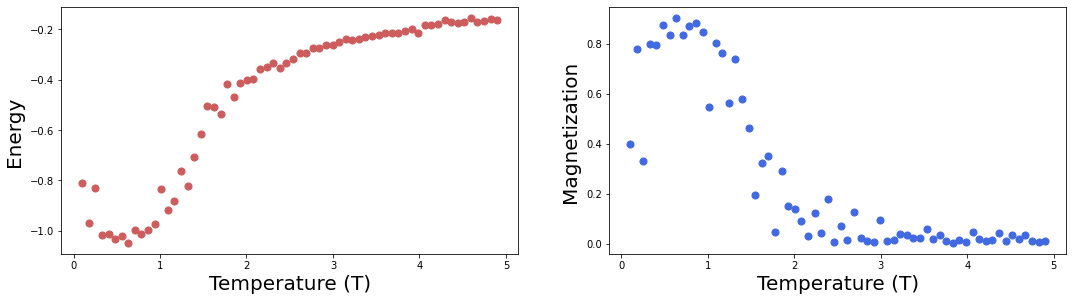

In [19]:
# изобразим значения энергии и магнетизма на графике

f = plt.figure(figsize=(18, 10));


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         
plt.axis('tight');
# plt.savefig('No_J_WS.png', dpi=600);

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

# plt.savefig('No_J_WS.png', dpi=600);

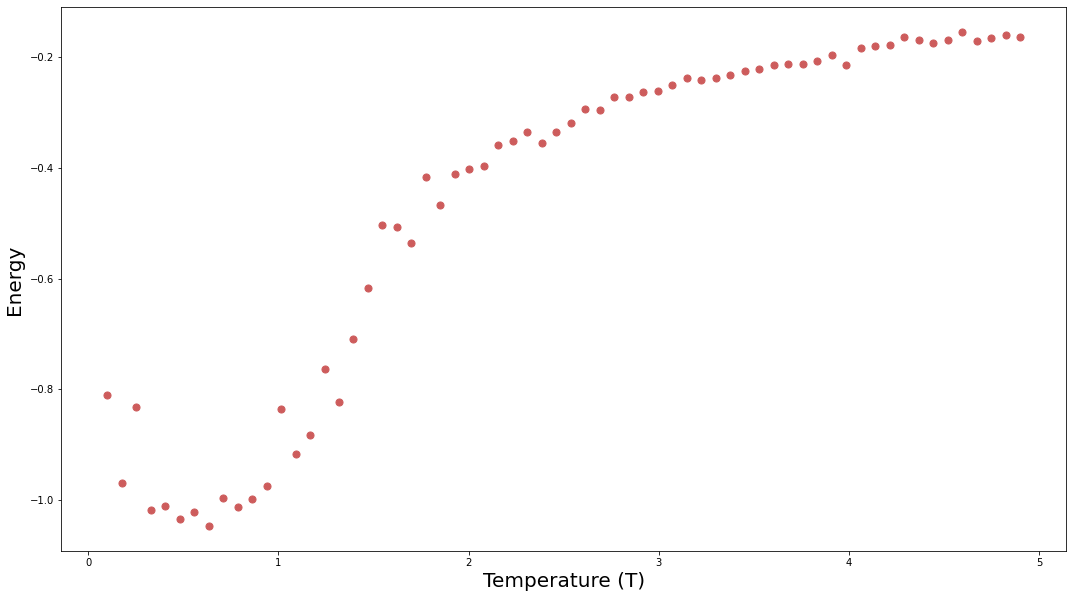

In [21]:
f = plt.figure(figsize=(18, 10));

plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         
plt.axis('tight');
plt.savefig('J_WS_energy.png', dpi=600);

In [49]:
# Граф с экспоненциальным распределением степени вершин
NODES_NUM: int = 107
SEED: int = 5102021
np.random.seed(SEED)
exp_g = exponential_graph(n=NODES_NUM)

# Присвоим каждому узлу графа ориентированность

spins = np.random.choice(
    a=[-1, 1], 
    p=[.5, .5], 
    size=NODES_NUM
)

for node in exp_g.nodes:
    
    exp_g.nodes[node]['spin'] = spins[node]
    exp_g.nodes[node]['is_active'] = (spins[node] + 1) / 2
    
for edge in exp_g.edges():
    
    exp_g.edges[edge]['J'] = uniform(0.1, 1)
    
    
logger.info('Graph is generated. Spins are configured. ')


2021-10-16 20:10:37.613 - [INFO] root [527785590.<module>:25]: Graph is generated. Spins are configured. 


In [50]:
np.random.seed(SEED)
model = Ising()


In [51]:
nt = 32

T = np.linspace(3, 7, nt)  # сетка значений температур (от минимальной до максимальной столько раз, сколько задали)
E, M = np.zeros(nt), np.zeros(nt)    # начальные матрицы значений энергии и магнетизма

In [52]:
for tt in range(nt):
    
    logger.info(f'Going {tt}')
    
    M[tt], E[tt] = model.simulate(
        G=exp_g.copy(), 
        temp=T[tt], 
        steps=3000
    )

2021-10-16 20:10:38.371 - [INFO] root [1062418191.<module>:3]: Going 0
2021-10-16 20:11:07.991 - [INFO] root [1062418191.<module>:3]: Going 1
2021-10-16 20:11:33.568 - [INFO] root [1062418191.<module>:3]: Going 2
2021-10-16 20:11:59.570 - [INFO] root [1062418191.<module>:3]: Going 3
2021-10-16 20:12:25.810 - [INFO] root [1062418191.<module>:3]: Going 4
2021-10-16 20:12:51.639 - [INFO] root [1062418191.<module>:3]: Going 5
2021-10-16 20:13:17.327 - [INFO] root [1062418191.<module>:3]: Going 6
2021-10-16 20:13:42.977 - [INFO] root [1062418191.<module>:3]: Going 7
2021-10-16 20:14:09.086 - [INFO] root [1062418191.<module>:3]: Going 8
2021-10-16 20:14:34.601 - [INFO] root [1062418191.<module>:3]: Going 9
2021-10-16 20:15:01.085 - [INFO] root [1062418191.<module>:3]: Going 10
2021-10-16 20:15:27.164 - [INFO] root [1062418191.<module>:3]: Going 11
2021-10-16 20:15:53.216 - [INFO] root [1062418191.<module>:3]: Going 12
2021-10-16 20:16:18.825 - [INFO] root [1062418191.<module>:3]: Going 13
20

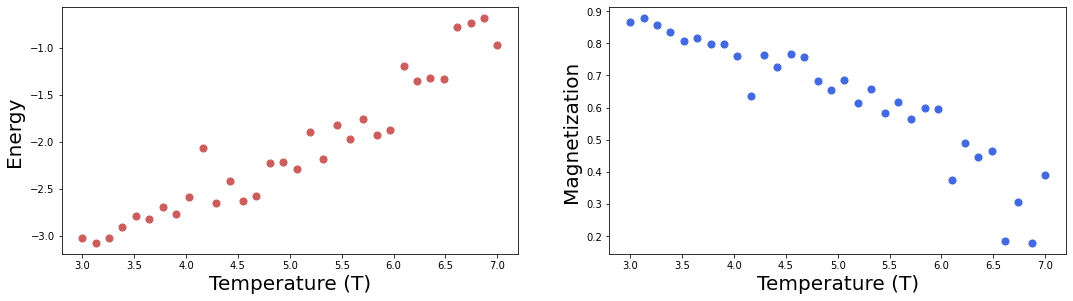

In [53]:
# изобразим значения энергии и магнетизма на графике

f = plt.figure(figsize=(18, 10));


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

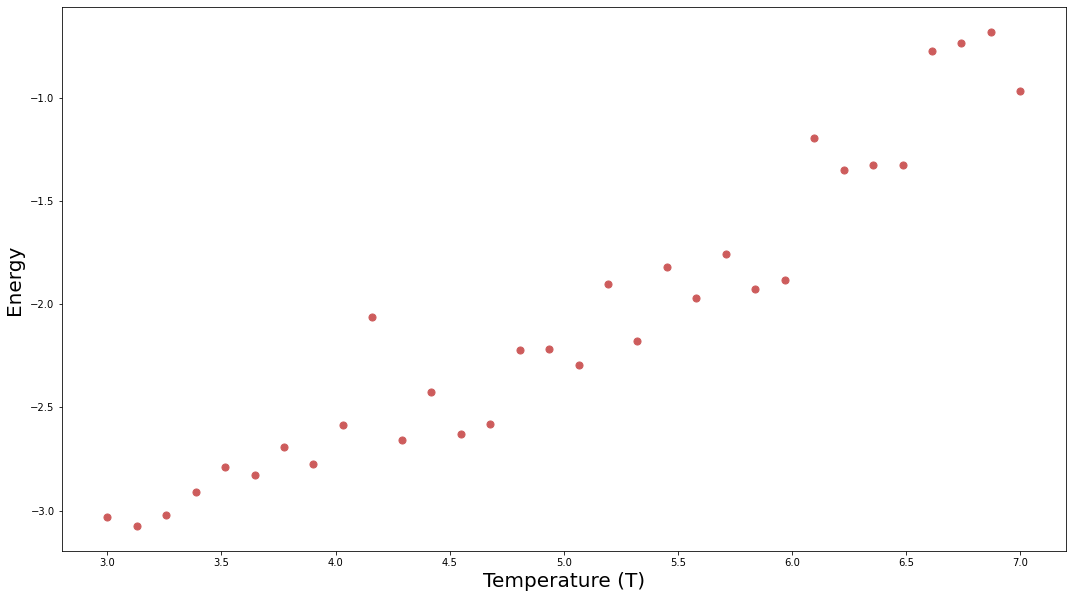

In [55]:
f = plt.figure(figsize=(18, 10));

plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.savefig('J_exp_energy.png', dpi=600);